In [59]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    # LinearRegression,
    LogisticRegression,
    Trainer,
    clusters
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [60]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 20
SIZE = 100
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [61]:
X, y = clusters(SIZE, std_0 = 1.3, std_1 = 1.6, generator=GENERATOR);

In [62]:
print("Generated X:", X, "\nGenerated y:", y, sep='\n')
print("\nShape of X: ", X.shape, "\nShape of y: ", y.shape, sep='\n')

Generated X:
tensor([[-4.9501e-01, -1.0665e+00],
        [-1.8291e+00, -5.7372e+00],
        [-2.1181e+00, -4.6049e+00],
        [-3.0560e+00, -5.0861e+00],
        [-3.9778e+00, -8.5666e-01],
        [-3.5102e+00, -4.8247e+00],
        [-3.9462e+00, -3.7273e+00],
        [-3.9995e+00, -2.0088e+00],
        [-8.6499e-01, -3.2075e+00],
        [-3.6466e+00, -2.4285e+00],
        [-3.9856e+00, -1.5982e+00],
        [-1.9590e+00, -8.1519e-01],
        [-1.3371e+00, -1.3147e+00],
        [-2.2064e+00, -1.2648e+00],
        [-3.3011e+00, -2.9457e+00],
        [-3.3270e+00, -1.8822e+00],
        [-4.8001e+00, -4.1326e+00],
        [-3.2904e+00, -7.6743e-01],
        [-2.5855e+00, -3.5519e+00],
        [-2.6026e+00, -4.0070e+00],
        [-5.0248e+00, -1.7057e+00],
        [-4.1437e+00, -3.7815e+00],
        [-4.6564e+00, -2.4038e-01],
        [-4.6050e+00, -3.6343e+00],
        [-4.1880e+00, -3.8556e+00],
        [-2.8986e+00, -2.3164e+00],
        [-3.6344e+00, -1.4512e+00],
        [-4.058

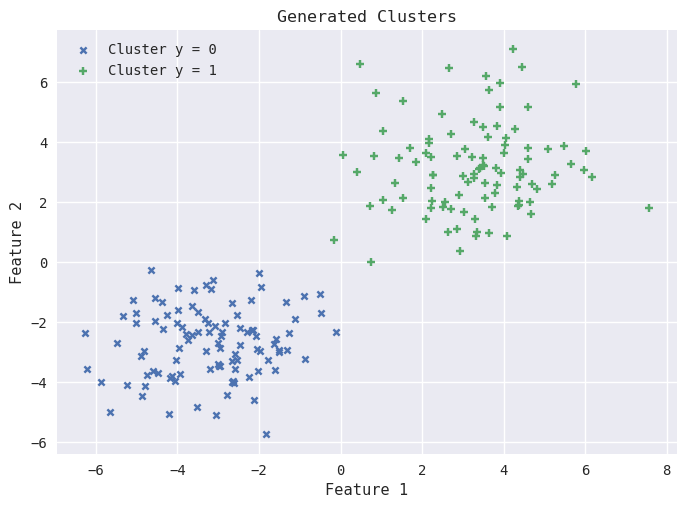

In [63]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='Cluster y = 0', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='Cluster y = 1', s=40)
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Clusters')
plt.show()

In [64]:
Model = LogisticRegression(in_dims=2).to(DEVICE)

In [65]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[-4.9501e-01, -1.0665e+00],
         [-1.8291e+00, -5.7372e+00],
         [-2.1181e+00, -4.6049e+00],
         [-3.0560e+00, -5.0861e+00],
         [-3.9778e+00, -8.5666e-01],
         [-3.5102e+00, -4.8247e+00],
         [-3.9462e+00, -3.7273e+00],
         [-3.9995e+00, -2.0088e+00],
         [-8.6499e-01, -3.2075e+00],
         [-3.6466e+00, -2.4285e+00],
         [-3.9856e+00, -1.5982e+00],
         [-1.9590e+00, -8.1519e-01],
         [-1.3371e+00, -1.3147e+00],
         [-2.2064e+00, -1.2648e+00],
         [-3.3011e+00, -2.9457e+00],
         [-3.3270e+00, -1.8822e+00],
         [-4.8001e+00, -4.1326e+00],
         [-3.2904e+00, -7.6743e-01],
         [-2.5855e+00, -3.5519e+00],
         [-2.6026e+00, -4.0070e+00],
         [-5.0248e+00, -1.7057e+00],
         [-4.1437e+00, -3.7815e+00],
         [-4.6564e+00, -2.4038e-01],
         [-4.6050e+00, -3.6343e+00],
         [-4.1880e+00, -3.8556e+00],
         [-2.8986e+00, -2.3164e+00],
         [-3.6344e+00, -1.4512e+00],
 

In [66]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [67]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.BCELoss(reduction='mean'),        # Binary Cross-entropy Loss (For classification)
    device=DEVICE
)

In [68]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([-0.9642,  1.1864], device='cuda:0')
	Epoch 1 | Bias: tensor([0.2255], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.7855,  1.2964], device='cuda:0')
	Epoch 1 | Bias: tensor([0.2203], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.6927,  1.3464], device='cuda:0')
	Epoch 1 | Bias: tensor([0.2232], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.5955,  1.3968], device='cuda:0')
	Epoch 1 | Bias: tensor([0.2218], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.4883,  1.4465], device='cuda:0')
	Epoch 1 | Bias: tensor([0.2127], device='cuda:0')
Epoch 1/20 | Loss: 0.8204
	| Validation Loss: 0.1136

	Epoch 2 | Weights: tensor([-0.4325,  1.4740], device='cuda:0')
	Epoch 2 | Bias: tensor([0.2093], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.3869,  1.4928], device='cuda:0')
	Epoch 2 | Bias: tensor([0.2062], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.3226,  1.5172], device='cuda:0')
	Epoch 2 | Bias: tensor([0.2018], device='cuda:0')
	Epoch 2 | Weights: tensor

In [69]:
print("Train Loss:", train_loss, "\nValidation Loss:", val_loss, sep='\n')

Train Loss:
{0: 0.8203670680522919, 1: 0.17205068916082383, 2: 0.09316683039069176, 3: 0.06544710993766785, 4: 0.05127345658838749, 5: 0.042598965018987654, 6: 0.03673286996781826, 7: 0.032475119829177855, 8: 0.029248774237930774, 9: 0.026769571751356126, 10: 0.02471943888813257, 11: 0.02303881160914898, 12: 0.02163603249937296, 13: 0.0204407817684114, 14: 0.019409660995006562, 15: 0.01850268505513668, 16: 0.017705102264881135, 17: 0.017001079954206945, 18: 0.016371642611920832, 19: 0.015803908836096524}

Validation Loss:
{0: 0.11362862214446068, 1: 0.06438246741890907, 2: 0.04520527832210064, 3: 0.044160356279462576, 4: 0.016128246672451496, 5: 0.018139786086976528, 6: 0.01541873812675476, 7: 0.011368082836270332, 8: 0.01665856596082449, 9: 0.009934607427567244, 10: 0.007243136642500758, 11: 0.007157997693866491, 12: 0.012349775061011314, 13: 0.007964596152305603, 14: 0.012253940803930163, 15: 0.005363788455724716, 16: 0.005468494258821011, 17: 0.0059098920319229364, 18: 0.00484488671

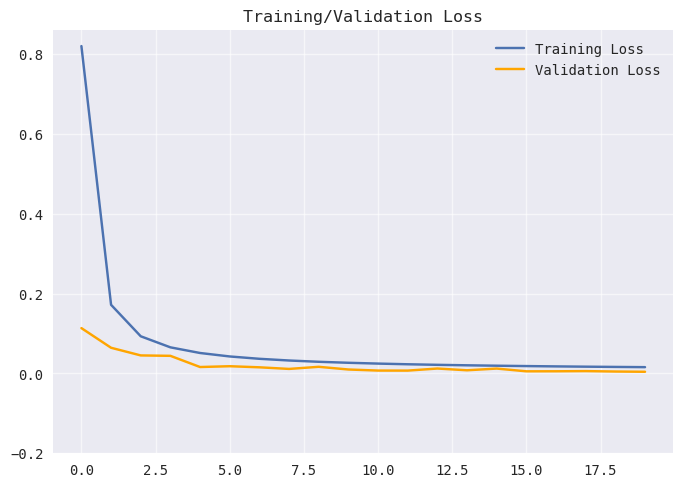

In [72]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=-.2)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [73]:
print(f"Predicted Model Parameters:", "Weights: {}".format(Model.w), "Bias: {}".format(Model.b), sep="\n")

Predicted Model Parameters:
Weights: Parameter containing:
tensor([0.4358, 1.8273], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([0.1477], device='cuda:0', requires_grad=True)


In [74]:
T = torch.tensor(np.linspace(X.min(), X.max(), SIZE).reshape(SIZE, 1), dtype=DTYPE, device=DEVICE)
T = torch.cat([T, T], dim=1)

with torch.no_grad():
    yT = Model(T)

print("Tensor T to plot the boundary:", T, sep='\n')
print("Results:", yT.float(), sep='\n')

Tensor T to plot the boundary:
tensor([[-6.2624, -6.2624],
        [-6.1228, -6.1228],
        [-5.9831, -5.9831],
        [-5.8435, -5.8435],
        [-5.7038, -5.7038],
        [-5.5641, -5.5641],
        [-5.4245, -5.4245],
        [-5.2848, -5.2848],
        [-5.1452, -5.1452],
        [-5.0055, -5.0055],
        [-4.8659, -4.8659],
        [-4.7262, -4.7262],
        [-4.5866, -4.5866],
        [-4.4469, -4.4469],
        [-4.3073, -4.3073],
        [-4.1676, -4.1676],
        [-4.0280, -4.0280],
        [-3.8883, -3.8883],
        [-3.7487, -3.7487],
        [-3.6090, -3.6090],
        [-3.4694, -3.4694],
        [-3.3297, -3.3297],
        [-3.1901, -3.1901],
        [-3.0504, -3.0504],
        [-2.9108, -2.9108],
        [-2.7711, -2.7711],
        [-2.6315, -2.6315],
        [-2.4918, -2.4918],
        [-2.3521, -2.3521],
        [-2.2125, -2.2125],
        [-2.0728, -2.0728],
        [-1.9332, -1.9332],
        [-1.7935, -1.7935],
        [-1.6539, -1.6539],
        [-1.5142,

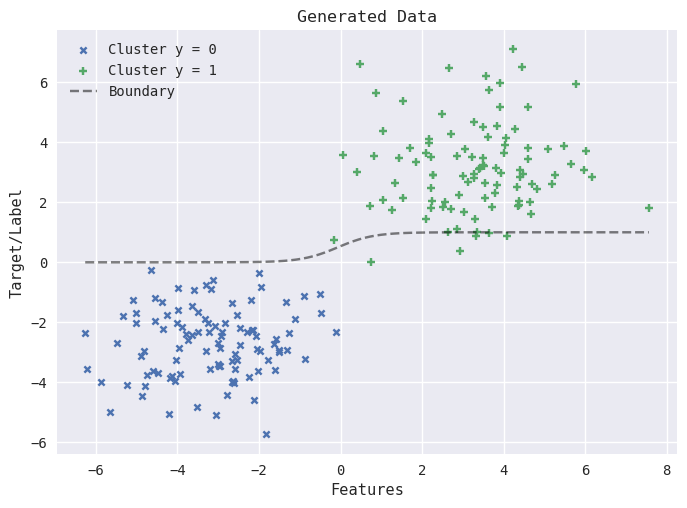

In [75]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='Cluster y = 0', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='Cluster y = 1', s=40)
# Decision Boundary
plt.plot(
    T[:, 1].cpu(),
    yT.cpu(),
    alpha=.5,
    color='black',
    linestyle='--',
    label="Boundary"
);

plt.xlabel("Features");
plt.ylabel("Target/Label");
plt.title("Generated Data");
plt.legend(loc='best');
plt.show();